In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

In [2]:
df = pd.read_csv("spam.csv", encoding='latin1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.rename({'v1':'is_spam', 'v2':'email'}, axis =1, inplace=True)
df.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [5]:
df.describe()

,is_spam,email
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df.isnull().sum()

is_spam    0
email      0
dtype: int64

In [7]:
df.duplicated().any()

True

In [8]:
no_dup_df = df.drop_duplicates(['email'])

In [9]:
no_dup_df.describe()

,is_spam,email
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


# EDA

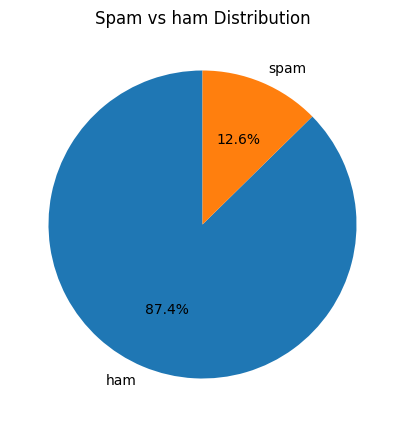

In [10]:
plt.figure(figsize=(8,5))
plt.pie(no_dup_df['is_spam'].value_counts(), labels=no_dup_df['is_spam'].value_counts().index, startangle=90, autopct='%1.1f%%')
plt.title('Spam vs ham Distribution')
plt.show()

In [11]:
no_dup_df['email_length'] = no_dup_df['email'].apply(len)
no_dup_df['word_count'] = no_dup_df['email'].apply(word_tokenize).apply(len)
no_dup_df['sentence_count'] = no_dup_df['email'].apply(sent_tokenize).apply(len)

C:\Users\felix\AppData\Local\Temp\ipykernel_29684\2297910522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dup_df['email_length'] = no_dup_df['email'].apply(len)
C:\Users\felix\AppData\Local\Temp\ipykernel_29684\2297910522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dup_df['word_count'] = no_dup_df['email'].apply(word_tokenize).apply(len)
C:\Users\felix\AppData\Local\Temp\ipykernel_29684\2297910522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [12]:
no_dup_df.head()

,is_spam,email,email_length,word_count,sentence_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


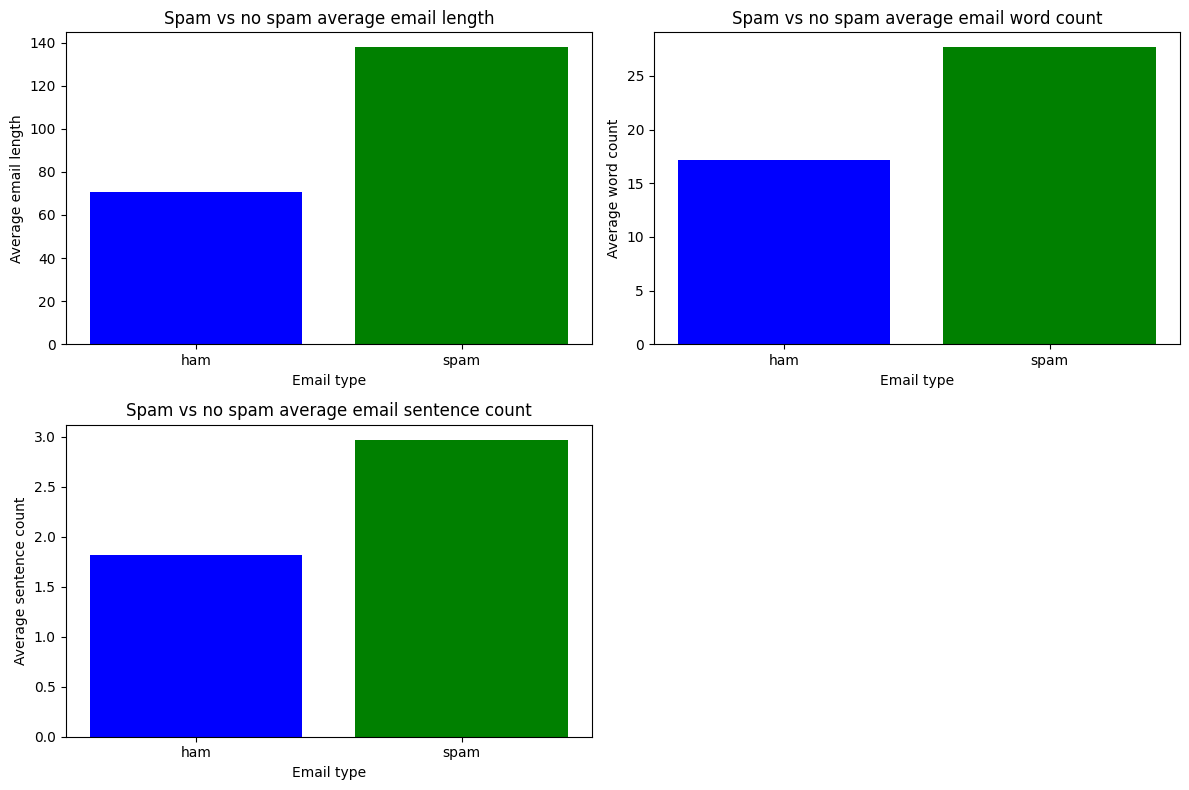

In [13]:
avg_mail_length = no_dup_df.groupby('is_spam')['email_length'].mean()
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.bar(avg_mail_length.index.astype("str"), avg_mail_length.values, color=['Blue', 'Green'])
plt.xlabel('Email type')
plt.ylabel('Average email length')
plt.title("Spam vs no spam average email length")

avg_word_count = no_dup_df.groupby("is_spam")['word_count'].mean()
plt.subplot(2,2,2)
plt.bar(avg_word_count.index.astype("str"), avg_word_count.values, color=['Blue', 'Green'])
plt.xlabel('Email type')
plt.ylabel('Average word count')
plt.title("Spam vs no spam average email word count")

avg_sent_count = no_dup_df.groupby("is_spam")["sentence_count"].mean()
plt.subplot(2,2,3)
plt.bar(avg_sent_count.index.astype("str"), avg_sent_count.values, color=['Blue', 'Green'])
plt.xlabel('Email type')
plt.ylabel('Average sentence count')
plt.title("Spam vs no spam average email sentence count")
plt.tight_layout()
plt.show()


# Preprocessing

In [14]:
tokens = no_dup_df['email'].apply(word_tokenize)

In [15]:
stop_words = set(stopwords.words('english'))
filtered_tokens = tokens.apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

## Lemmatization vs Stemming
Here, We will do seperate preprocessing steps. Generally, Lemmatization will produce better results but takes a bit longer to process, while Stemming will be a bit faster

In [16]:
stemmer = PorterStemmer()

In [17]:
stems = filtered_tokens.apply(lambda stem: [stemmer.stem(token) for token in stem])

In [18]:
lemmatizer = WordNetLemmatizer()

In [19]:
# Map NLTK POS to WordNet POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [20]:
lemmatized_series_pos = filtered_tokens.apply(
    lambda tokens: [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tag(tokens)
    ]
)

In [ ]:
no_dup_df['lemmatized_sent'] = [' '.join(word) for word in lemmatized_series_pos]
no_dup_df['stemmed_sent'] = [' '.join(word) for word in stems]


In [ ]:
no_dup_df['is_spam'] = no_dup_df['is_spam'].map({'spam': 1, 'ham': 0})

In [35]:
no_dup_df['stemmed_sent']

0       go jurong point , crazi .. avail bugi n great ...
1                           ok lar ... joke wif u oni ...
2       free entri 2 wkli comp win fa cup final tkt 21...
3             u dun say earli hor ... u c alreadi say ...
4              nah n't think goe usf , live around though
                              ...                        
5567    2nd time tri 2 contact u. u å£750 pound prize ...
5568                           ì_ b go esplanad fr home ?
5569                        piti , * mood . ... suggest ?
5570    guy bitch act like 'd interest buy someth els ...
5571                                     rofl . true name
Name: stemmed_sent, Length: 5169, dtype: object

# Splitting

In [36]:
X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(no_dup_df['stemmed_sent'], no_dup_df['is_spam'], test_size=0.3)

In [24]:
X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = train_test_split(no_dup_df['lemmatized_sent'], no_dup_df['is_spam'], test_size=0.3)

In [37]:
X_train_stemmed

379     taught ranjith sir call . sm like . becau he v...
4317                            ... take mokka player : )
5483    li hai ... bore da lectur repeat last week stu...
951                            shb b ok lor ... thanx ...
4054    school start . stay . 's weather like . food ....
                              ...                        
4837    boy made fun today . ok problem . sent one mes...
2398                            yo yo yo byatch whassup ?
5427    santa call ! would littl one like call santa x...
396     actual sleep still might u call back . text gr...
1578    make girl happi ? 's difficult make girl happi...
Name: stemmed_sent, Length: 3618, dtype: object

## Embedding

In [25]:
vectorizer = CountVectorizer()

In [26]:
X_train_lemmatized = vectorizer.fit_transform(X_train_lemmatized)
X_test_lemmatized = vectorizer.transform(X_test_lemmatized)

In [38]:
X_train_stemmed = vectorizer.fit_transform(X_train_stemmed)
X_test_stemmed = vectorizer.transform(X_test_stemmed)

# Model

In [41]:
model = SVC()

In [42]:
model.fit(X_train_lemmatized, y_train_lemmatized)

SVC()

In [44]:
y_pred_lemmatized = model.predict(X_test_lemmatized)
print(accuracy_score(y_test_lemmatized, y_pred_lemmatized))

0.9806576402321083


In [45]:
model.fit(X_train_stemmed, y_train_stemmed)

SVC()

In [46]:
y_pred_stemmed = model.predict(X_test_stemmed)
print(accuracy_score(y_test_stemmed, y_pred_stemmed))

0.9774339136041263
